In [1]:
import numpy as np
import pandas as pd
import yaml
import joblib
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from utils import model_metrics_rms, proteins_share

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

os.chdir('/workspace') # change to the root directory of the project

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [3]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_filtered.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

peaks.shape, pixels.shape

((6104831, 3492), (6104831, 15))

# Define the densities and a threshold for each pixel density

In [4]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

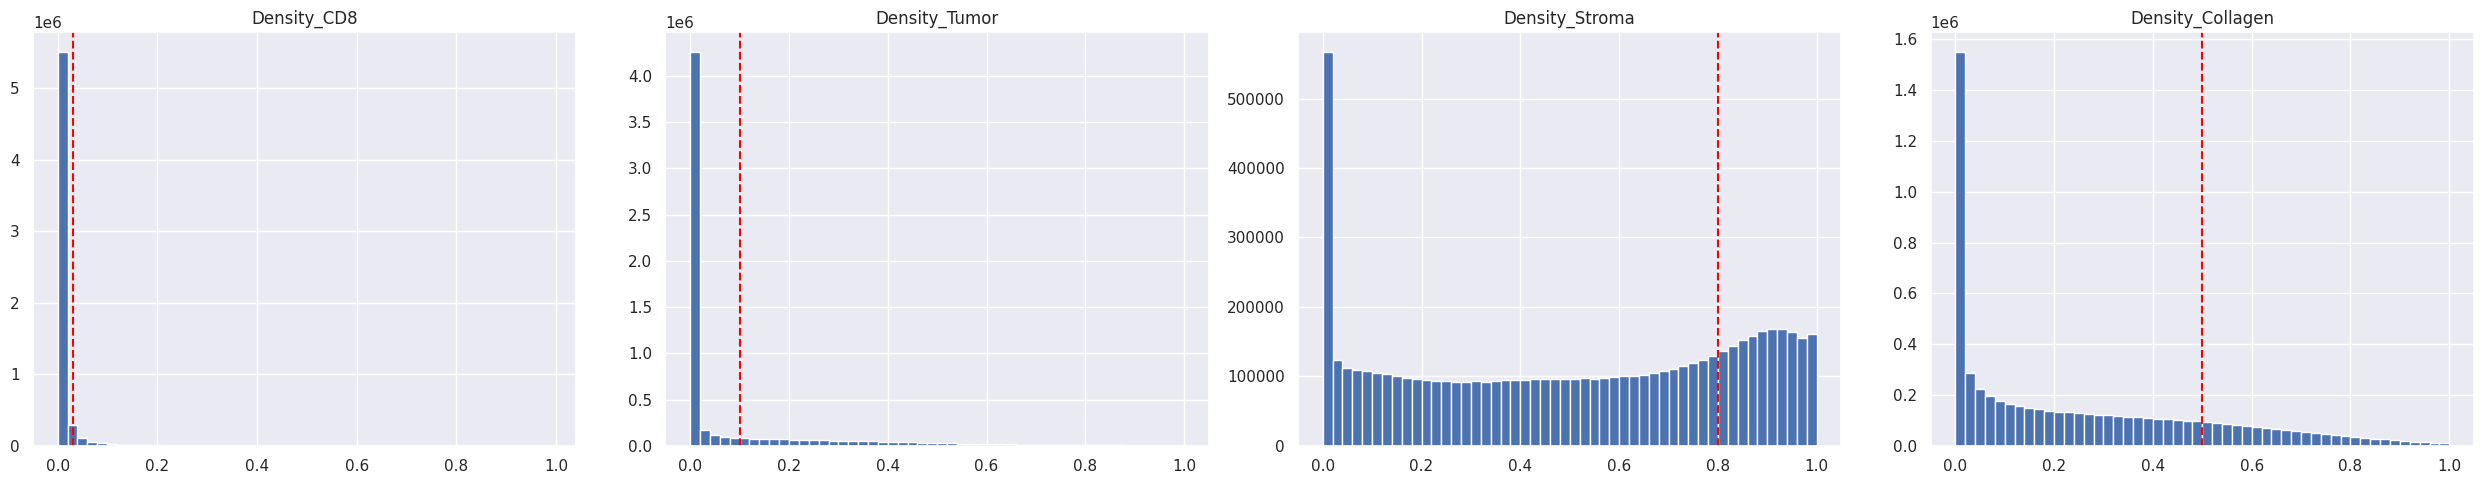

In [5]:
# Plot a histogram of the densities
fig, axes = plt.subplots(1, 4, figsize=(25, 5), tight_layout=True)
for i, (ax, density) in enumerate(zip(axes, densities)):
    ax.hist(pixels[density], bins=50)
    ax.axvline(threshold[density], color='red', linestyle='--')
    ax.set_title(density)
    # ax.set_yscale('log')
plt.show()

# Clean the Defective pixels

In [6]:
# Exclude the pixels outside the lesion
# peaks = peaks[pixels["Density_Lesion"] > 0.5]
# pixels = pixels[pixels["Density_Lesion"] > 0.5]

# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

In [7]:
# Concatenate the quadratic features with the original DataFrame
# peaks = pd.concat([peaks, pd.DataFrame({f"{col}^2": peaks[col] ** 2 for col in peaks.columns}, index=peaks.index)], axis=1)

# Standardize the data

In [8]:
# Extract the column names of the peaks
peaks_columns = peaks.columns

# Fit the scaler to the peaks in the lesion
scaler = StandardScaler()
scaler.fit(peaks[pixels["Density_Lesion"] > 0.5])

# Standardize the peaks
peaks = scaler.transform(peaks)
peaks = pd.DataFrame(peaks, columns=peaks_columns)

In [9]:
# Load the models
model_reg = joblib.load(f"{path_models}model_reg.joblib")
model_lasso = joblib.load(f"{path_models}model_lasso.joblib")
model_ridge = joblib.load(f"{path_models}model_ridge.joblib")
model_en = joblib.load(f"{path_models}model_en.joblib")

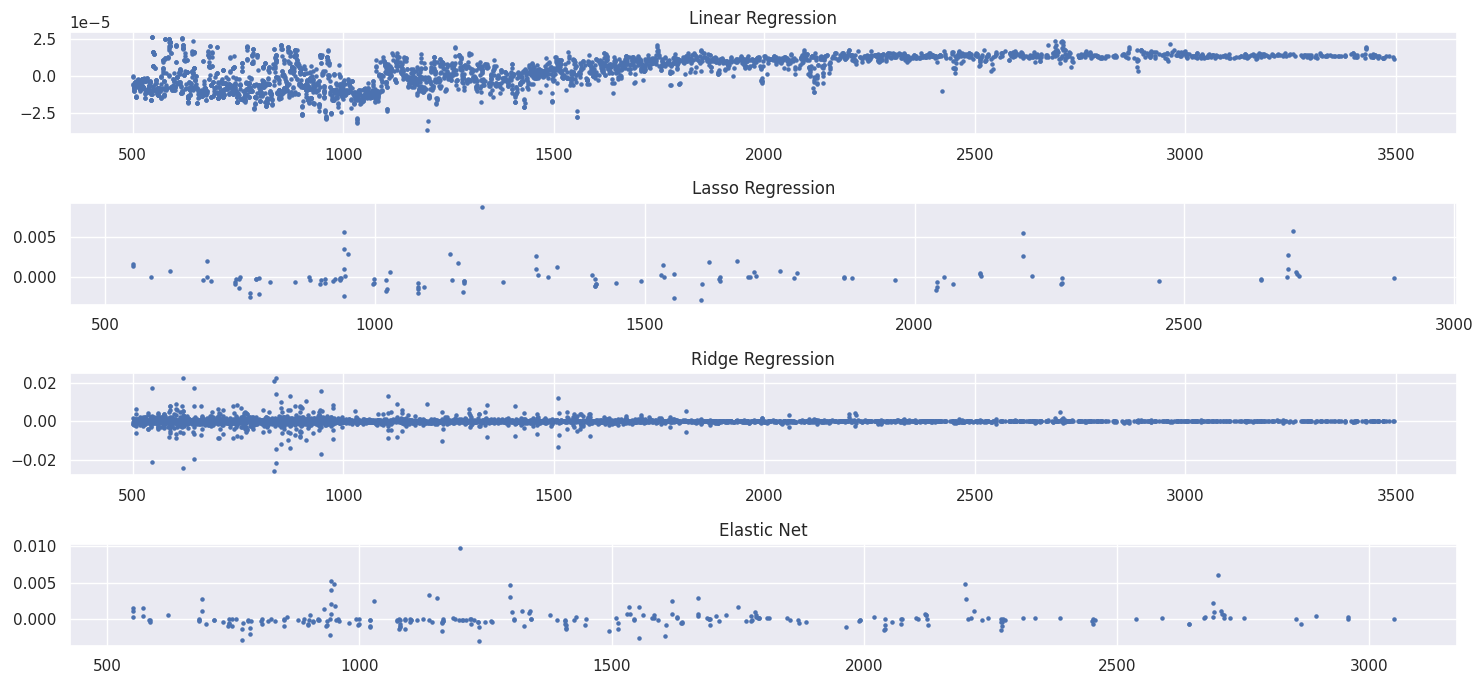

In [10]:
# Plot the coefficients of the models
fig, axes = plt.subplots(4, 1, figsize=(15, 7), tight_layout=True)

for ax, model, name in zip(axes,
                           [model_reg, model_lasso, model_ridge, model_en],
                           ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
    ax.scatter(peaks.columns[model.coef_ != 0].values.astype(float), model.coef_[model.coef_ != 0], s=5)
    ax.set_title(name)
plt.show()

In [11]:
# Extract the non-zero masses in the Lasso and Elastic Net models
masses_lasso = peaks.columns.values[model_lasso.coef_ != 0].astype(float)
masses_en = peaks.columns.values[model_en.coef_ != 0].astype(float)

In [12]:
# Count the non-zero coefficients
print (f"Number of features: {len(peaks.columns)}")
print(f"Number of non-zero coefficients:")
print(f"Linear Regression: {np.sum(model_reg.coef_ != 0)}")
print(f"Lasso Regression: {np.sum(model_lasso.coef_ != 0)}") 
print(f"Ridge Regression: {np.sum(model_ridge.coef_ != 0)}")
print(f"Elastic Net: {np.sum(model_en.coef_ != 0)}")

Number of features: 3492
Number of non-zero coefficients:
Linear Regression: 3492
Lasso Regression: 122
Ridge Regression: 3492
Elastic Net: 265


In [13]:
# Select the peaks that are in the Lasso
peaks_lasso = peaks.loc[:, peaks.columns.values[model_lasso.coef_ != 0]]

# Save the peaks that are in the Lasso
peaks_lasso.to_pickle(f"{path_results}peaks_lasso.pkl")

# Split the data into training and testing sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(peaks_lasso[pixels["Density_Lesion"] > 0.5].values,
                                                    pixels[pixels["Density_Lesion"] > 0.5]['Density_CD8'].values,
                                                    test_size=0.05,
                                                    random_state=42)

# Transform the target variablem

In [15]:
# Take the root mean square of the densities
y_train_rms = np.sqrt(y_train)
y_test_rms = np.sqrt(y_test)

# Perform a linear regression

In [16]:
# Create a linear regression model
model_reg_lasso = LinearRegression()

# Train the model
model_reg_lasso.fit(X_train, y_train_rms)

LinearRegression()

R-squared (Train): 0.11
R-squared (Test): 0.11
Mean Squared Error (Train): 4.22e-04
Mean Squared Error (Test): 4.12e-04
Deviance (Train): 2.23e-02
Deviance (Test): 2.21e-02


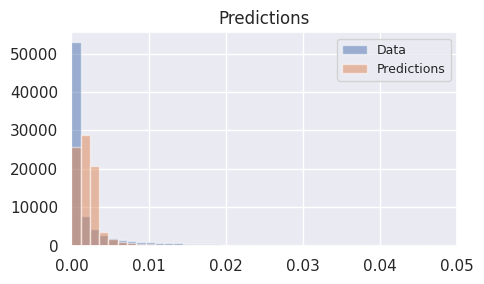

In [17]:
# perform the prediction
_ = model_metrics_rms(model_reg_lasso, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [18]:
# Create a ridge regression model
model_ridge_lasso = Ridge(alpha=0.01, max_iter=10**6, tol=1e-6)

# Train the model
model_ridge_lasso.fit(X_train, y_train_rms)

Ridge(alpha=0.01, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.19
R-squared (Test): 0.19
Mean Squared Error (Train): 4.00e-04
Mean Squared Error (Test): 3.92e-04
Deviance (Train): 1.92e-02
Deviance (Test): 1.91e-02


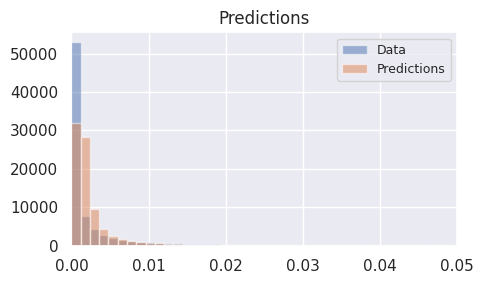

In [19]:
_ = model_metrics_rms(model_ridge_lasso, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

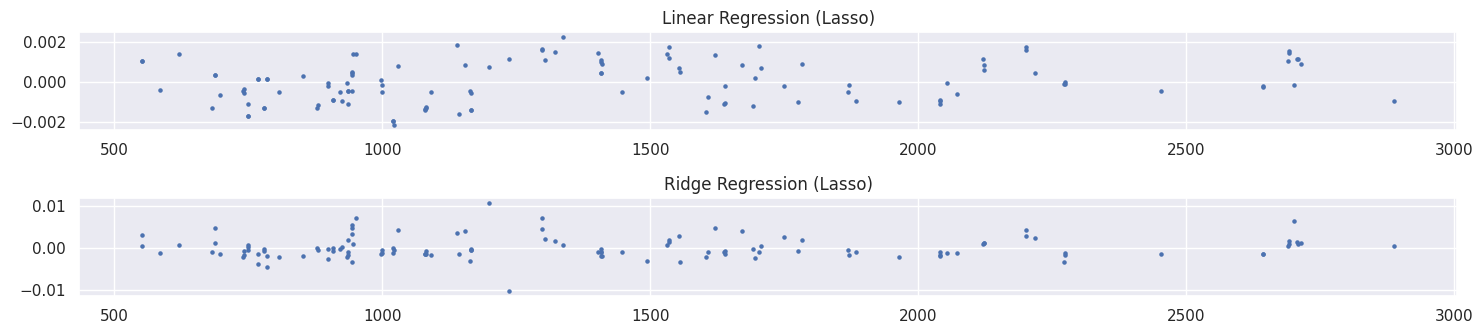

In [20]:
# Plot the coefficients of the models
fig, axes = plt.subplots(2, 1, figsize=(15, 3.5), tight_layout=True)

for ax, model, name in zip(axes,
                           [model_reg_lasso, model_ridge_lasso],
                           ['Linear Regression (Lasso)', 'Ridge Regression (Lasso)']):
    ax.scatter(peaks_lasso.columns.values.astype(float), model.coef_[model.coef_ != 0], s=5)
    ax.set_title(name)
plt.show()

# Perform a linear regression on the selected features

In [21]:
# Apply the weights to the peaks
pixels['Reg_CD8'] = np.clip(a=model_reg.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_Ridge_CD8'] = np.clip(a=model_ridge.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_lasso_CD8'] = np.clip(a=model_reg_lasso.predict(peaks_lasso.values) ** 2, a_min=0, a_max=1)
pixels['Reg_lasso_Ridge_CD8'] = np.clip(a=model_ridge_lasso.predict(peaks_lasso.values) ** 2, a_min=0, a_max=1)

In [26]:
predictions = ['Density_CD8', 'Reg_CD8', 'Reg_lasso_CD8', 'Reg_Ridge_CD8', 'Reg_lasso_Ridge_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=5, figsize=(25, 100), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    max_density = np.quantile(pixels_lame['Density_CD8'], 0.99)
    for j, prediction in enumerate(predictions):
        axs[i, j].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=pixels_lame[prediction],
                          s=(pixels_lame['x_warped'].max() - pixels_lame['x_warped'].min()) / len(pixels_lame),
                          marker='s', cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99))
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('equal')
        axs[i, j].invert_yaxis()
        fig.colorbar(axs[i, j].collections[0], ax=axs[i, j])
        
plt.savefig(f"{path_results}predictions_CD8_lasso.png")
plt.close()

In [23]:
# save the models
joblib.dump(model_reg_lasso, f"{path_models}model_reg_lasso.joblib")
joblib.dump(model_ridge_lasso, f"{path_models}model_ridge_lasso.joblib")

['data/MALDI_IHC/correlations/results/models/model_ridge_lasso.joblib']

# Extract the proteins shared peptides mass

In [24]:
path_peptides = "data/MALDI_IHC/results/peptides_mass_immuno_counts"

# Extract the proteins shared peptides mass with the masses from the Lasso model
proteins_shares = proteins_share(path_peptides=path_peptides,
                                 mass_arr=masses_lasso,
                                 tolerance=0.1)

# Calculate the number of peptides mass in proteins shares
n_peptides_share = {protein: len(peptides) for protein, peptides in proteins_shares.items()}

# Calculate the number of peptides mass in proteins
n_peptides = {protein: len(pd.read_csv(f"{path_peptides}/{protein}_HUMAN_peptide_mass.csv")) for protein in proteins_shares.keys()}

# Create a DataFrame with the number of peptides
df_peptides = pd.DataFrame({'Protein': list(proteins_shares.keys()),
                            'Peptides': list(n_peptides.values()),
                            'Peptides_Share': list(n_peptides_share.values())})

# Calculate the percentage of peptides in the shares
df_peptides['Percentage'] = df_peptides['Peptides_Share'] / df_peptides['Peptides']

df_peptides.head()

,Protein,Peptides,Peptides_Share,Percentage
0,CO6A5,175,14,0.080000
1,CO6A3,214,13,0.060748
2,PGBM,214,12,0.056075
3,MXRA5,185,11,0.059459
4,COBA2,103,11,0.106796


In [25]:
# Save the proteins_shares dictionary
with open(f"{path_results}proteins_shares_lasso.yml", "w") as f:
    yaml.dump(proteins_shares, f)

# Save the peptides shares
df_peptides.to_csv(f"{path_results}proteins_shares_lasso.csv", index=False)